In [18]:
#!pip install tensorflow~=2.6.0
#!pip install keras~=2.6.0
#pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import os
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import time
from IPython import display
from PIL import Image as PImage
%matplotlib inline

#plt.imshow(trainImages[1,...])
def normalize(layer):
    return tf.divide(tf.subtract(layer,tf.reduce_min(layer) ), tf.subtract(tf.reduce_max(layer),tf.reduce_min(layer)))
#take random noise as input and a starting shape that has dimensions ((7,14,28), (7,14,28), (128, 256, 512)
print(tf.__version__)

2.6.0


In [19]:
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def make_generator_model(): 
    model = tf.keras.Sequential() 
    model.add(layers.Dense(256*7*7, use_bias=False, input_shape=(100,))) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    model.add(layers.Reshape((7, 7, 256))) 
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init)) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) 

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) 

    model.add(layers.Conv2D(3, (3, 3), padding='same', use_bias=False, activation='tanh')) 
    return model

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init, input_shape=[56, 56, 3]))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(56, 56, 32)

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2))   #shape(14, 14, 64)

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(7, 7, 128)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(7, 7, 256)
    model.add(layers.Dropout(0.3))  #dropout is used to prevent overfitting by setting inputs to 0 at a rate determined by paremeter 
                                   #while training. While have to test how this function affects performance

    model.add(layers.Flatten()) #fits all elements into 1 dimension
    model.add(layers.Dense(1,activation='sigmoid'))  #Creates a densely-connected layer of size 1

    opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [21]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [22]:
# generate n fake samples with class labels
#def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
#	X = np.random.rand(224 * 224 * 3 * n_samples)
	# reshape into a batch of color images
#	X = X.reshape((n_samples, 224, 224, 3))
	# generate 'fake' class labels (0)
#	y = np.zeros((n_samples, 1))
#	return X, y

#def generate_fake_samples(n_samples):
#	generator = make_generator_model()
#	noise = tf.random.normal([n_samples, 100]) #replace 1 with batch size
#	generated_image = generator(noise, training=False)
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20000, n_batch=155):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	print(bat_per_epo)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			#plt.imshow((X_fake[0]+1)/2)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))



1
>1, 1/1, d1=0.693, d2=0.570 g=0.684


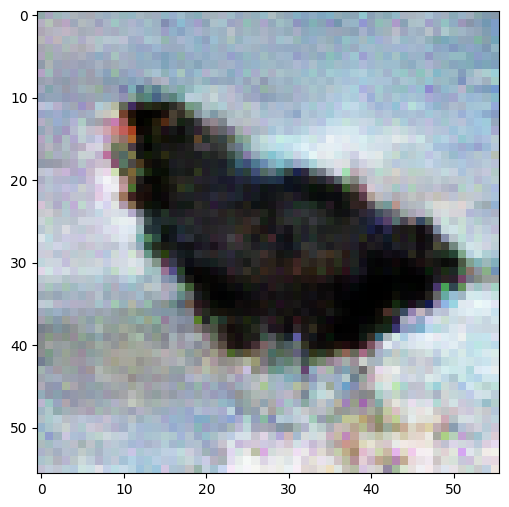

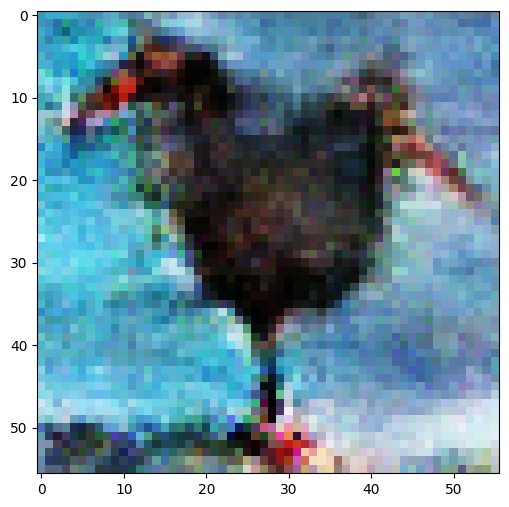

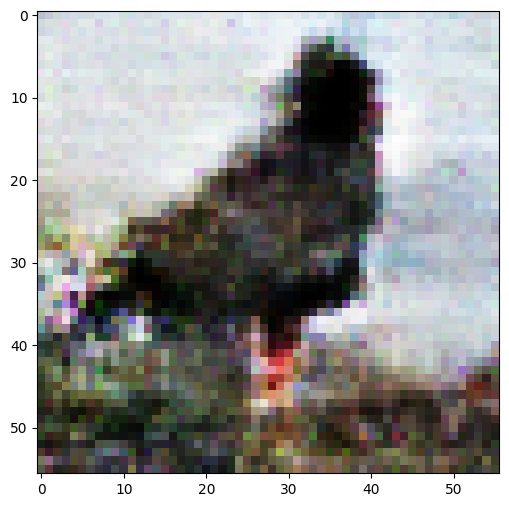

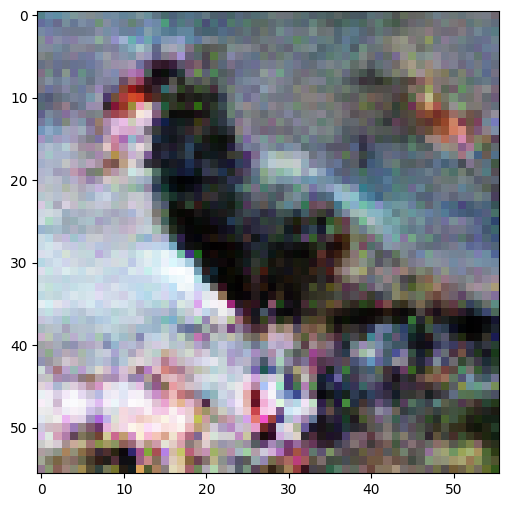

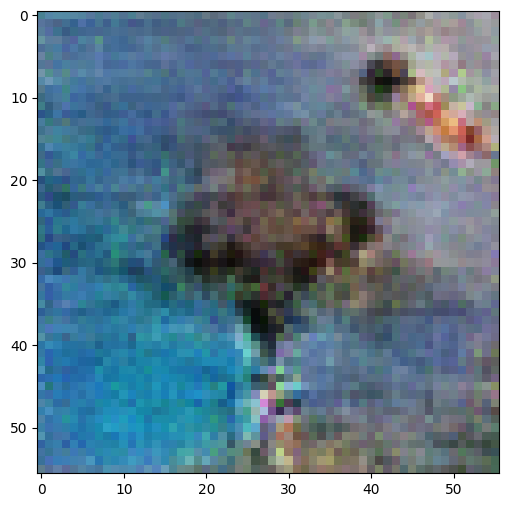

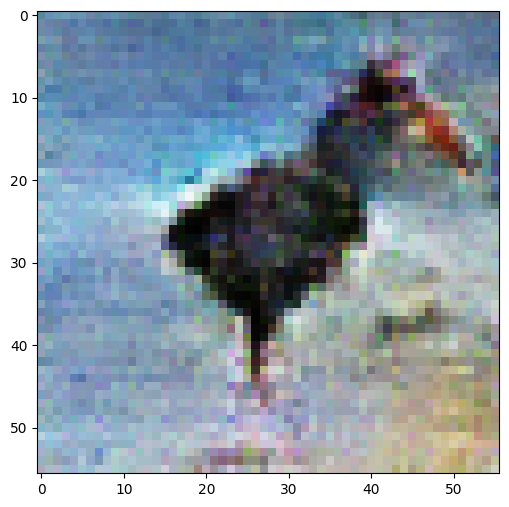

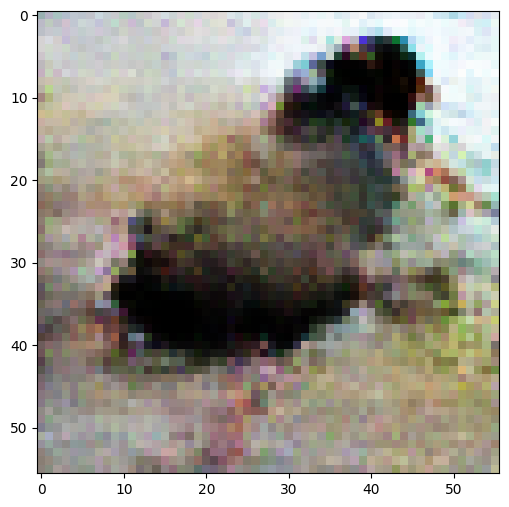

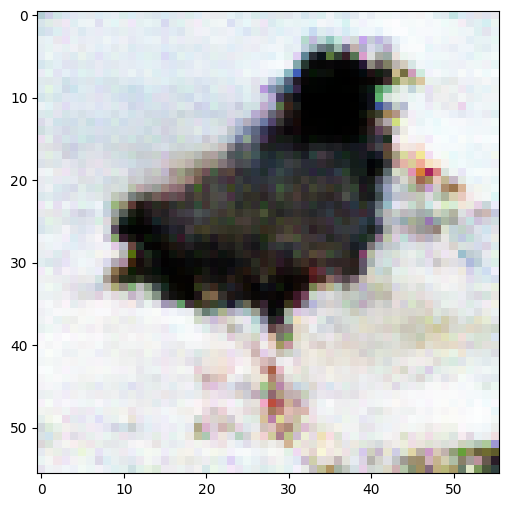

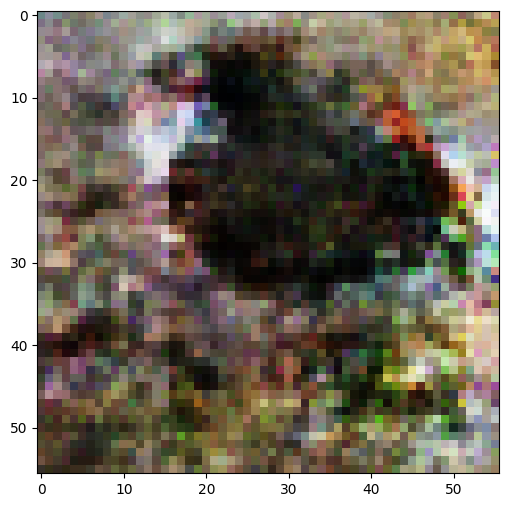

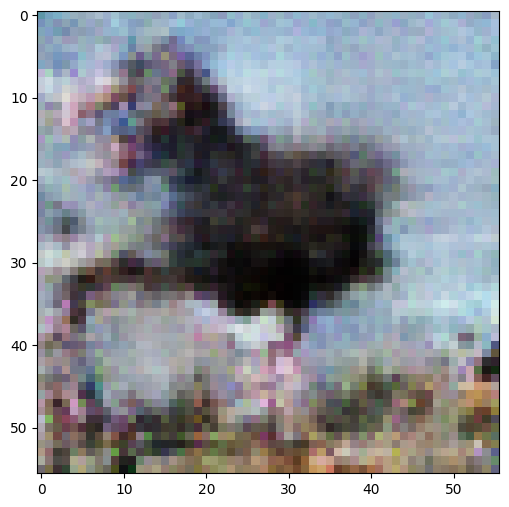

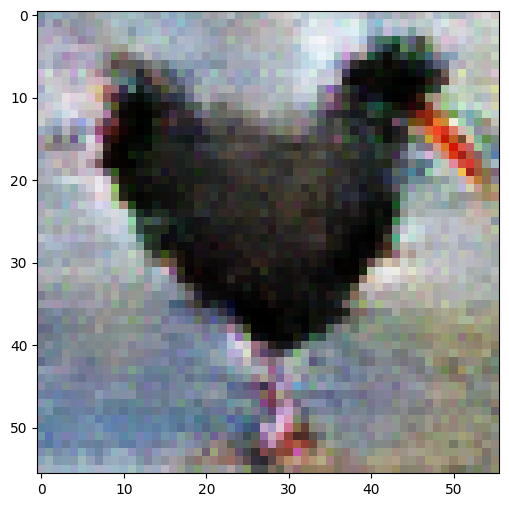

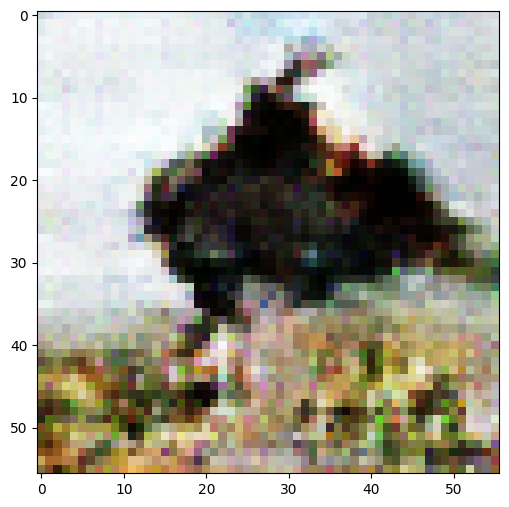

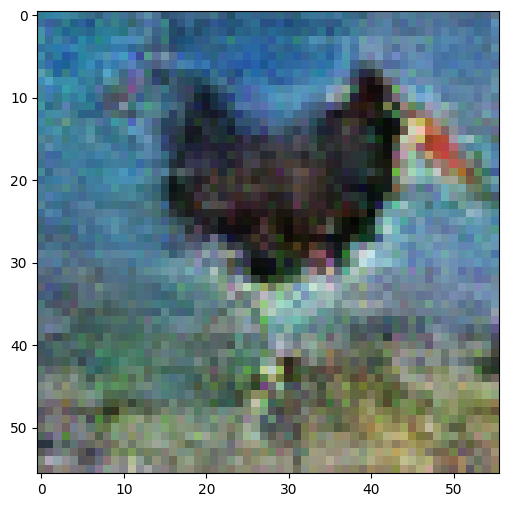

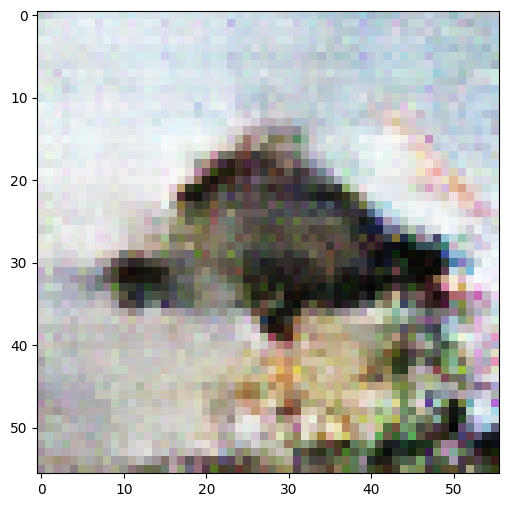

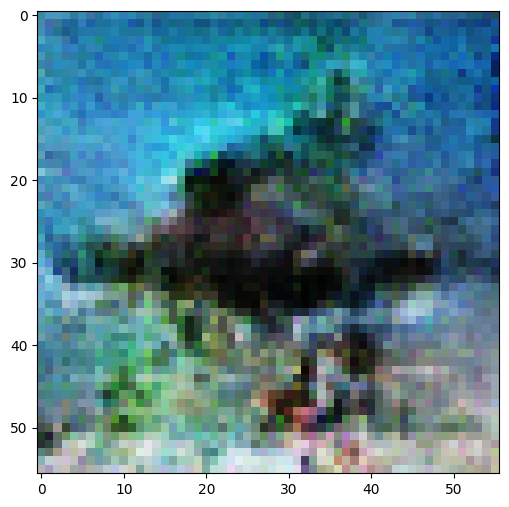

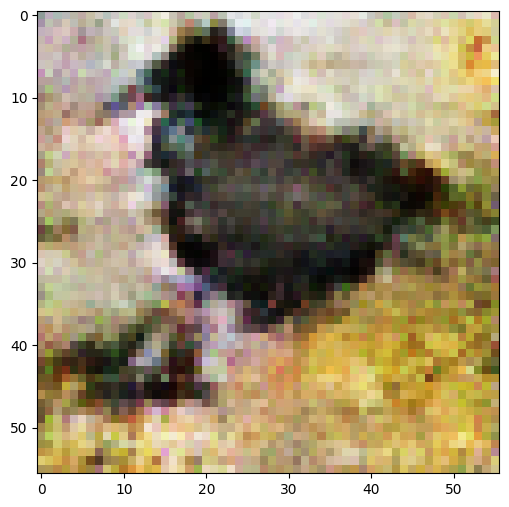

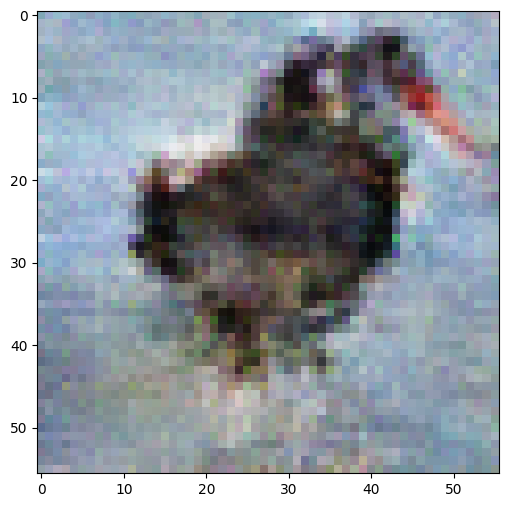

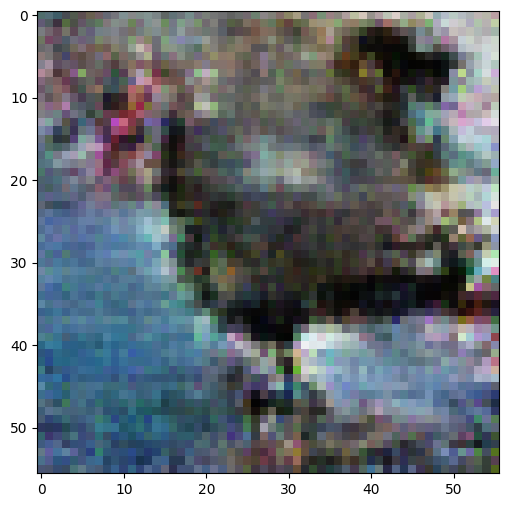

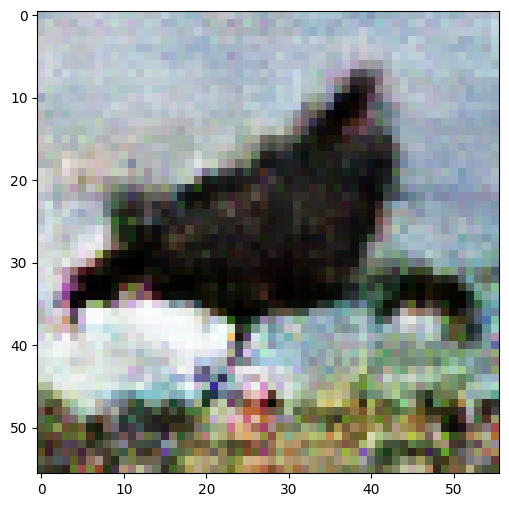

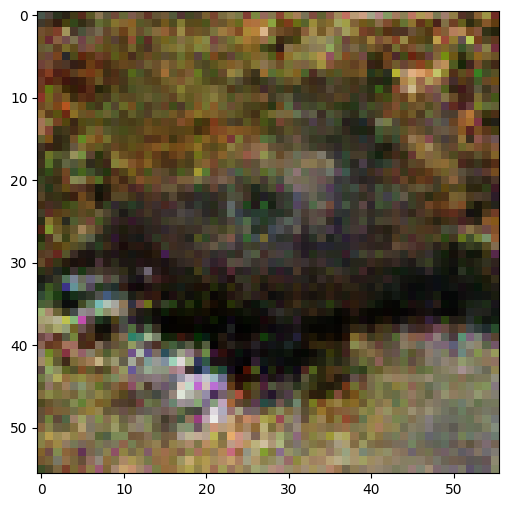

In [25]:
temp_discrim = make_discriminator_model() 
generator = make_generator_model() 
tempImages = np.zeros((2,56,56,3))
gan_model = define_gan(generator, temp_discrim)
#need to initialize weights of generator so create temporary GAN and train once to initialize
train(generator, temp_discrim, gan_model, tempImages, 100, n_epochs=1, n_batch=2)
#Loading the weights from file overwrites temporary weights but has identical model arcitecture
generator.load_weights('30minGAN.h5')    
while(1):
  condition = input("Generate New Image? (Y/N): \n")
  condition.lower()
  if(condition == 'y' or condition == 'yes'):
    for i in range(0,10):
        noise = tf.random.normal([1, 100])                      #Generating new random noise to input into generator
        generated_image = generator.predict(noise)         #Sending in Input to Generator, Recieving Image
        generated_image = (generated_image+1)/2       #scale from 0 to 1
        plt.figure(figsize=(6,6))                             #Plotting the Image
        #print(generated_image[0, :, :, :].shape)                #check that image has scaled to correct size
        plt.imshow(generated_image[0, :, :, :])
        plt.show()

  else: break;